In [1]:
import xarray as xr

def extract_string(input_string):
    # Find the index of the first occurrence of a digit in the input string
    index = next((i for i, c in enumerate(input_string) if c.isdigit()), None)

    if index is not None:
        # Extract the substring from the start of the input string to the index
        extracted_string = input_string[:index]
        return extracted_string
    else:
        return None


def fetch_results_as_xarray_arb_var(handles, qubits, measurement_axis, var_name = None):
    """
    Fetches measurement results as an xarray dataset.
    Parameters:
    - handles : A dictionary containing stream handles, obtained through handles = job.result_handles after the execution of the program.
    - qubits (list): A list of qubits.
    - measurement_axis (dict): A dictionary containing measurement axis information, e.g. {"frequency" : freqs, "flux",}.
    Returns:
    - ds (xarray.Dataset): An xarray dataset containing the fetched measurement results.
    """
    if var_name is None:
        stream_handles = handles.keys()
        meas_vars = list(set([extract_string(handle) for handle in stream_handles if extract_string(handle) is not None]))
    else:
        meas_vars = [var_name]
    values = [
        [handles.get(f"{meas_var}{i + 1}").fetch_all() for i, qubit in enumerate(qubits)] for meas_var in meas_vars
    ]
    if np.array(values).shape[-1] == 1:
        values = np.array(values).squeeze(axis=-1)
    measurement_axis["qubit"] = [qubit.name for qubit in qubits]
    measurement_axis = {key: measurement_axis[key] for key in reversed(measurement_axis.keys())}
    
    ds = xr.Dataset(
        {f"{meas_var}": ([key for key in measurement_axis.keys()], values[i]) for i, meas_var in enumerate(meas_vars)},
        coords=measurement_axis,
    )

    return ds


In [2]:
# Import and dependencies
from qualibrate import QualibrationNode, NodeParameters
from iqcc_calibration_tools.quam_config.components import Quam
from iqcc_calibration_tools.analysis.plot_utils import QubitGrid, grid_iter
from iqcc_calibration_tools.quam_config.lib.qua_datasets import convert_IQ_to_V
from iqcc_calibration_tools.storage.save_utils import fetch_results_as_xarray, load_dataset
from qualang_tools.units import unit
from qualang_tools.multi_user import qm_session
from qm import SimulationConfig
from qm.qua import *
from typing import Optional, List, Literal
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from qualang_tools.results import progress_counter, fetching_tool
from datetime import datetime
from iqcc_calibration_tools.quam_config.macros import qua_declaration, active_reset, readout_state
from qualang_tools.loops import from_array
u = unit(coerce_to_integer=True)


2025-09-26 12:31:38,864 - qm - INFO     - Starting session: 5a63c20e-c2ee-4b7b-9294-a848dd6a448d


In [ ]:
class Parameters(NodeParameters):
    # Define which qubits to measure
    qubits: Optional[List[str]] = None

    # Experiment parameters
    num_repetitions: int = 100
    min_wait_time_in_ns: int = 16
    max_wait_time_in_ns: int = 5000
    wait_time_step_in_ns: int = 48
    detuning: int = 2 * u.MHz

    # Bayesian parameters
    f_min: float = 1
    f_max: float = 3
    df: float = 0.01
    
    alpha: float = -0.2
    beta: float = 0.8

    # Control parameters
    reset_type: Literal["active", "thermal"] = "thermal"
    use_state_discrimination: bool = True

    # Execution parameters
    simulate: bool = False
    simulation_duration_ns: int = 2500
    timeout: int = 100
    load_data_id: Optional[int] = None
    multiplexed: bool = False

# Create experiment node
node = QualibrationNode(name="FrequencyBayes", parameters=Parameters())
#node_id = get_node_id()

2025-09-26 12:31:49,592 - qualibrate - INFO - Creating node FrequencyBayes


In [6]:
# Initialize unit handling
u = unit(coerce_to_integer=True)

# Load QuAM configuration
machine = Quam.load()

# Generate hardware configurations
config = machine.generate_config()

# Connect to quantum control hardware
if node.parameters.load_data_id is None:
    qmm = machine.connect()

# Get qubit objects

# if node.parameters.qubits is None or node.parameters.qubits == "":
#     qubits = machine.active_qubits
# else:
#     qubits = [machine.qubits[q] for q in node.parameters.qubits]

# qubits = [machine.qubits['qA1'],machine.qubits['qA2'], machine.qubits['qA3'], machine.qubits['qA4'], machine.qubits['qA5']]
qubits = [machine.qubits['Q6']]
v_f = np.arange(node.parameters.f_min, node.parameters.f_max + 0.5 * node.parameters.df, node.parameters.df)
num_qubits = len(qubits)

c:\Users\tomdv\OneDrive - QM Machines LTD\Documents\IQCC_Research\venv\Lib\site-packages\quam\components\channels.py:636: UserWarning: The 'thread' element argument is deprecated from qm.qua >= 1.2.2. Use 'core' instead.
  warnings.warn(


2025-09-26 12:32:12,190 - qm - INFO     - Performing health check
2025-09-26 12:32:12,278 - qm - INFO     - Cluster healthcheck completed successfully.


In [7]:
# Set up experiment parameters

n_reps = node.parameters.num_repetitions
idle_times = np.arange(
    node.parameters.min_wait_time_in_ns // 4,
    node.parameters.max_wait_time_in_ns // 4,
    node.parameters.wait_time_step_in_ns // 4,
)
detuning = node.parameters.detuning

# Define QUA program
with program() as BayesFreq:
    # Declare variables
    I, I_st, Q, Q_st, n, n_st = qua_declaration(num_qubits=num_qubits)

    if node.parameters.use_state_discrimination:
        state = [declare(int) for _ in range(num_qubits)]
        state_st = [declare_stream() for _ in range(num_qubits)]

    t = declare(int)
    phase = declare(fixed)

    # Bayes variables
    
    frequencies = declare(fixed, value=v_f.tolist())

    Pf = declare(fixed, value=(np.ones(len(v_f)) / len(v_f)).tolist())
    Pf_st = [declare_stream() for _ in range(num_qubits)]

    norm = declare(fixed)
    s = declare(int)  # Variable for qubit state classification

    t_sample = declare(fixed)

    f = declare(fixed)

    C = declare(fixed)
    rk = declare(fixed)

    alpha = declare(fixed, value=node.parameters.alpha)
    beta = declare(fixed, value=node.parameters.beta)

    # Main experiment loop
    for i, qubit in enumerate(qubits):
        # Set flux bias
        machine.set_all_fluxes(flux_point="joint", target=qubit)

        # Averaging loop
        with for_(n, 0, n < n_reps, n + 1):
            save(n, n_st)

            # Time sweep loop
            with for_(*from_array(t, idle_times)):
                assign(phase, Cast.mul_fixed_by_int(detuning * 1e-9, 4 * t))
                # Reset qubit
                if node.parameters.reset_type == "active":
                    active_reset(qubit, "readout")
                else:
                    qubit.resonator.wait(qubit.thermalization_time * u.ns)
                    qubit.align()

                # Excitation
                qubit.xy.play("x90")
                qubit.align()

                # Wait time
                qubit.xy.wait(t)
                qubit.xy.frame_rotation_2pi(phase)
                qubit.xy.play("x90")
                qubit.align()

                # Measurement
                readout_state(qubit, state[i])
                save(state[i], state_st[i])

                
                assign(rk, Cast.to_fixed(state[i]) - 0.5)  # Fix: use scalar variable
                assign(t_sample, Cast.mul_fixed_by_int(1e-3, t * 4))

                f_idx = declare(int)
                with for_(f_idx, 0, f_idx < len(v_f), f_idx + 1):
                    assign(C, Math.cos2pi(frequencies[f_idx] * t_sample))
                    assign(
                        Pf[f_idx],
                        (0.5 + rk * (alpha + beta * C))
                        * Pf[f_idx],
                    )
                
                assign(norm, Cast.to_fixed(1.0 / Math.sum(Pf)))

                with for_(f_idx, 0, f_idx < len(v_f), f_idx + 1):
                    assign(Pf[f_idx], norm * Pf[f_idx])
                    save(Pf[f_idx], Pf_st[i])
                
                reset_frame(qubit.xy.name)
            
            with for_(f_idx, 0, f_idx < len(v_f), f_idx + 1):
                    assign(Pf[f_idx], 1 / len(v_f))
        # Stream processing
    with stream_processing():
        n_st.save("n")
        for i in range(num_qubits):
            
            Pf_st[i].buffer(len(v_f)).buffer(len(idle_times)).buffer(n_reps).save(f"Pf{i + 1}")
            state_st[i].buffer(n_reps,len(idle_times)).save(f"state{i + 1}")

In [8]:
with qm_session(qmm, config, timeout=node.parameters.timeout ) as qm:
    job = qm.execute(BayesFreq)

    results = fetching_tool(job, ["n"], mode="live")
    while results.is_processing():
        # Fetch results
        n = results.fetch_all()[0]
        # Progress bar
        progress_counter(n, node.parameters.num_repetitions, start_time=results.start_time)


c:\Users\tomdv\OneDrive - QM Machines LTD\Documents\IQCC_Research\venv\Lib\site-packages\qm\program\_qua_config_schema.py:1880: DeprecationWarning: 'version' is deprecated since "1.2.2" and will be removed in "1.3.0". Please remove it from the Qua config.
  warnings.warn(


2025-09-26 12:32:17,683 - qm - INFO     - Opening QM
2025-09-26 12:32:17,684 - qm - INFO     - Clearing queue
2025-09-26 12:32:17,862 - qm - INFO     - Adding program to queue.
Progress: [##################################################] 100.0% (n=100/100) --> elapsed time: 4.01s
Progress: [##################################################] 100.0% (n=100/100) --> elapsed time: 4.30s
Progress: [##################################################] 100.0% (n=100/100) --> elapsed time: 4.57s
Progress: [##################################################] 100.0% (n=100/100) --> elapsed time: 4.86s


c:\Users\tomdv\OneDrive - QM Machines LTD\Documents\IQCC_Research\venv\Lib\site-packages\qm\api\v2\qm_api_old.py:976: DeprecationWarning: qm.get_running_job is deprecated since "1.2.0" and will be removed in "1.4.0". This method is going to be removed, please use `qm.get_jobs(status=['Running'])`
  warnings.warn(


2025-09-26 12:32:24,867 - qm - INFO     - Closing QM


In [9]:
ds_single = fetch_results_as_xarray_arb_var(job.result_handles, qubits, {"t": idle_times*4, "repetition": np.arange(1,n_reps+1)}, "state")
ds_Pf = fetch_results_as_xarray_arb_var(job.result_handles, qubits, {"vf" : v_f,"t": idle_times*4, "repetition": np.arange(1,n_reps+1)}, "Pf")
ds = xr.merge([ds_single, ds_Pf])

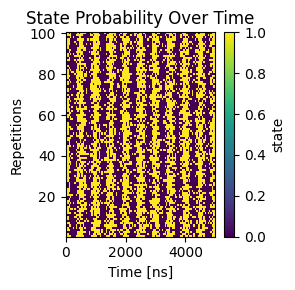

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,num_qubits,figsize=(3*num_qubits, 3))
if num_qubits == 1:
    ds_single.state.plot(ax=ax)
    ax.set_xlabel('Time [ns]')
    ax.set_ylabel('Repetitions')
    ax.set_title('State Probability Over Time')
else:
    for i in range(num_qubits):
        ds_single.state.isel(qubit=i).plot(ax=ax[i])
        ax[i].set_xlabel('Time [ns]')
        ax[i].set_ylabel('Repetitions')
        ax[i].set_title('State Probability Over Time')


plt.tight_layout()
plt.show()

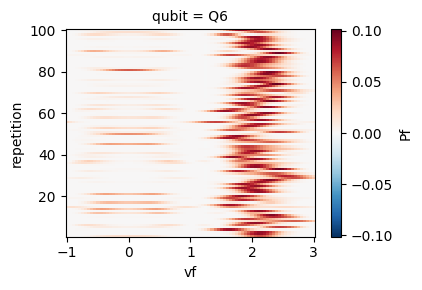

In [11]:
ds_Pf.Pf.isel(t=10).plot(col = "qubit")

NameError: name 'y_data_key' is not defined

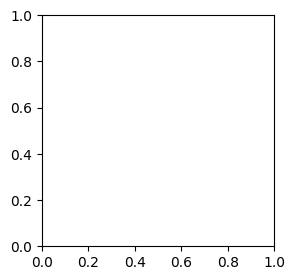

In [12]:
# Create qubit grid
grid = QubitGrid(ds, [q.grid_location for q in qubits])

# Loop over grid axes and qubits
for ax, qubit in grid_iter(grid):
    qubit_name = qubit["qubit"]
    t_vals = ds.t.values
    y_vals = ds[y_data_key].sel(qubit=qubit_name).values

    # Plot data with pcolormesh
    X, Y = np.meshgrid(t_vals, np.arange(1, n_reps + 1))
    pcm = ax.pcolormesh(X, Y, y_vals.T, shading='auto')
    ax.set_xlabel("Idle time [ns]")
    ax.set_ylabel("Repetition")
    ax.set_title(qubit_name)
    grid.fig.colorbar(pcm, ax=ax, label=f"{y_data_key}")
    ax.grid(True)

grid.fig.suptitle("Frequency Bayes Results")
plt.tight_layout()

# Save results
node.results = {
    "ds": ds,
    "figure": grid.fig
}
node.machine = machine
node.save()